In [78]:
import torch
from torch import nn
from pygad import torchga

def inverted_pendulum_linear(x, u, m=0.2, M=1.0, L=0.5, g=9.81):
    A = torch.tensor([
        [0, 1, 0, 0],
        [0, 0, (m * g) / M, 0],
        [0, 0, 0, 1],
        [0, 0, ((M + m) * g) / (M * L), 0]
    ])
    
    B = torch.tensor([[0, 1 / M, 0, 1 / (M * L)]]).T

    state_dot = torch.matmul(A, x.T) + torch.matmul(B, u.T)

    return state_dot.T

class controller(nn.Module):
    def __init__(self, state_dim=4, action_dim=1, max_action=20):
        super(controller, self).__init__()
        self.layer1 = nn.Linear(state_dim, 32)
        self.output = nn.Linear(32, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = torch.tanh(self.layer1(state))
        action = torch.tanh(self.output(x)) * self.max_action
        
        return action

def simulate_inverted_pendulum_nn(initial_state, target_state, controller, dt, t_end, m=0.2, M=1.0, L=0.5, g=9.81):
    state = initial_state.detach()
    error = target_state[:, 2] - state[:, 2]
    error_intg = error.detach()
    
    states, us, errors = [], [], [] 
    time = torch.arange(0, t_end, dt)
    for t in time:
        
        u = controller(state)
        state_dot = inverted_pendulum_linear(state, u, m, M, L, g)
        state_next = state + state_dot * dt
        
        states.append(state.detach())
        us.append(u.detach())
        errors.append(error.detach())
        
        state = state_next.detach()
        error = (target_state[:, 2] - state[:, 2]).detach()
        error_intg = error_intg + error

    return torch.stack(states), torch.stack(us), torch.stack(errors), time

def cost_function(initial_state, target_state, ctrl, dt=0.01, t_end=0.5):
    _, _, errors, _ = simulate_inverted_pendulum_nn(initial_state, target_state, ctrl, dt, t_end)
    cost = torch.abs(errors[:, 2]).sum().detach().numpy()
    
    return cost

def fitness_func(ga_instance, solution, sol_idx):
    global initial_state, target_state, torch_ga, ctrl, cost_function

    model_weights_dict = torchga.model_weights_as_dict(
        model=ctrl,
        weights_vector=solution)
    
    ctrl.load_state_dict(model_weights_dict)

    cost = cost_function(initial_state, target_state, ctrl, dt=0.04, t_end=1)
    solution_fitness = 1.0 / cost

    return solution_fitness

def on_generation(ga_instance):
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution()[1]}")

In [79]:
import pygad

dt, t_end, n = 0.01, 0.2, 250
ctrl = controller()

initial_state = torch.tensor([[0.0, 0.0, 0.2, 0.0] for _ in range(n)])
target_state = torch.tensor([[0.0, 0.0, 0.0, 0.0] for _ in range(n)])

torch_ga = torchga.TorchGA(model=ctrl,
                           num_solutions=n)

# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class
num_generations = 200 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=on_generation)

/Users/starkster/Desktop/autoreq/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation = 1
Fitness    = 0.7564250826835632
Generation = 2
Fitness    = 0.7564250826835632
Generation = 3
Fitness    = 0.9545820355415344
Generation = 4
Fitness    = 0.9545820355415344
Generation = 5
Fitness    = 0.9981738328933716
Generation = 6
Fitness    = 1.1335636377334595
Generation = 7
Fitness    = 1.1335636377334595
Generation = 8
Fitness    = 1.1661244630813599
Generation = 9
Fitness    = 1.1661244630813599
Generation = 10
Fitness    = 1.1661381721496582
Generation = 11
Fitness    = 1.1661381721496582
Generation = 12
Fitness    = 1.1717872619628906
Generation = 13
Fitness    = 1.2126237154006958
Generation = 14
Fitness    = 1.2898056507110596
Generation = 15
Fitness    = 1.3769214153289795
Generation = 16
Fitness    = 1.3769214153289795
Generation = 17
Fitness    = 1.3769214153289795
Generation = 18
Fitness    = 1.3769214153289795
Generation = 19
Fitness    = 1.3769214153289795
Generation = 20
Fitness    = 1.3769214153289795
Generation = 21
Fitness    = 1.3769214153289795
G

/Users/starkster/Desktop/autoreq/lib/python3.12/site-packages/pygad/visualize/plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


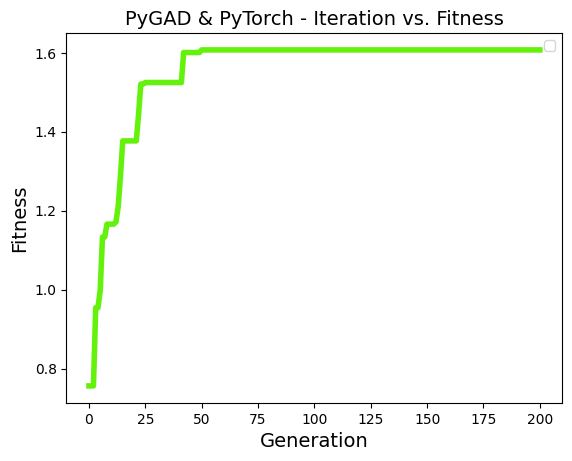

Fitness value of the best solution = 1.6073049306869507
Index of the best solution : 0


In [80]:
ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

In [81]:
model_weights_dict = torchga.model_weights_as_dict(
    model=ctrl,
    weights_vector=solution)

ctrl.load_state_dict(model_weights_dict)

<All keys matched successfully>

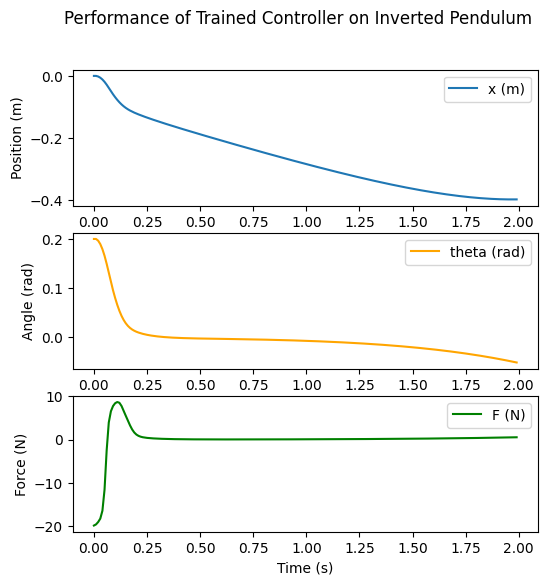

In [82]:
import matplotlib.pyplot as plt

initial_state = torch.tensor([[0.0, 0.0, 0.2, 0.0] for _ in range(1)])
target_state = torch.tensor([[0.0, 0.0, 0.0, 0.0] for _ in range(1)])
# Simulate using the trained actor
states, actions, errors, time = simulate_inverted_pendulum_nn(initial_state, target_state, ctrl, dt, t_end=2)

positions = states[:, 0, 0]  # Cart position x
angles = states[:, 0, 2]     # Pendulum angle theta

# Plot the results
plt.figure(figsize=(6, 6))

# Plot cart position
plt.subplot(3, 1, 1)
plt.plot(time, positions, label="x (m)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()

# Plot pendulum angle
plt.subplot(3, 1, 2)
plt.plot(time, angles, label="theta (rad)", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.legend()

# Plot actions
plt.subplot(3, 1, 3)
plt.plot(time, actions[:, 0], label="F (N)", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.suptitle("Performance of Trained Controller on Inverted Pendulum")
plt.show()
